In [1]:
!nvidia-smi

Sat Jan  8 09:42:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download moltean/fruits

 99% 1.27G/1.28G [00:26<00:00, 79.4MB/s]
100% 1.28G/1.28G [00:26<00:00, 52.5MB/s]


In [5]:
! unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

In [6]:
train_path = '/content/fruits-360_dataset/fruits-360/Training'
test_path = '/content/fruits-360_dataset/fruits-360/Test'

In [7]:
import tensorflow as tf 
import keras
from PIL import Image
import os
import pathlib
import numpy as np

In [8]:
tf.__version__

'2.7.0'

In [9]:
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [10]:
train_count = len(list(train_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))
print(f'Train : { train_count }')
print(f'Test : { test_count }')

Train : 67692
Test : 22688


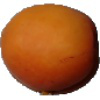

In [11]:
apricot = list(train_dir.glob('Apricot/*'))
Image.open(str(apricot[0]))

In [12]:
batch_size = 32
img_height = 100
img_width = 100

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [14]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 22688 files belonging to 131 classes.
Using 4537 files for validation.


In [15]:
class_name = train_ds.class_names
len(class_name)

131

In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns

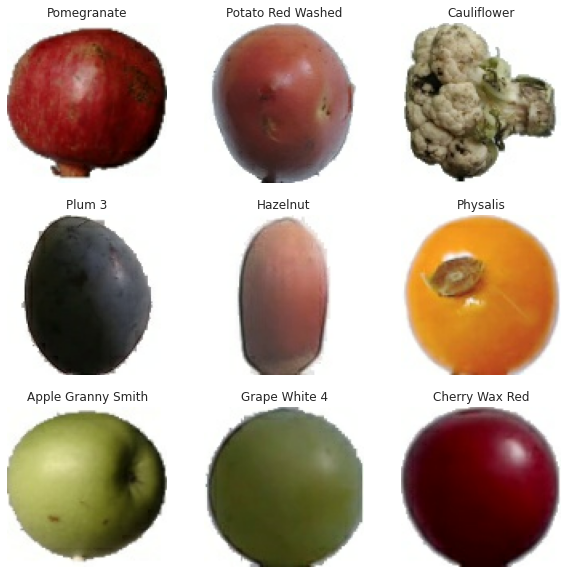

In [17]:
sns.set_theme()
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [18]:
for ib, lb in train_ds:
  print(ib.shape)
  print(lb.shape)
  break

(32, 100, 100, 3)
(32,)


In [19]:
from keras.models import Sequential
from keras.layers import Input, Rescaling, MaxPool2D, Conv2D, Dropout, Flatten, Dense

In [20]:
nodes = len(class_name)

model = Sequential([
                    Input(shape=(img_height, img_width, 3)),
                    Rescaling(1./255),
                    Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.2),
                    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.2),
                    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.5),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(nodes, activation='softmax')
])

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                    

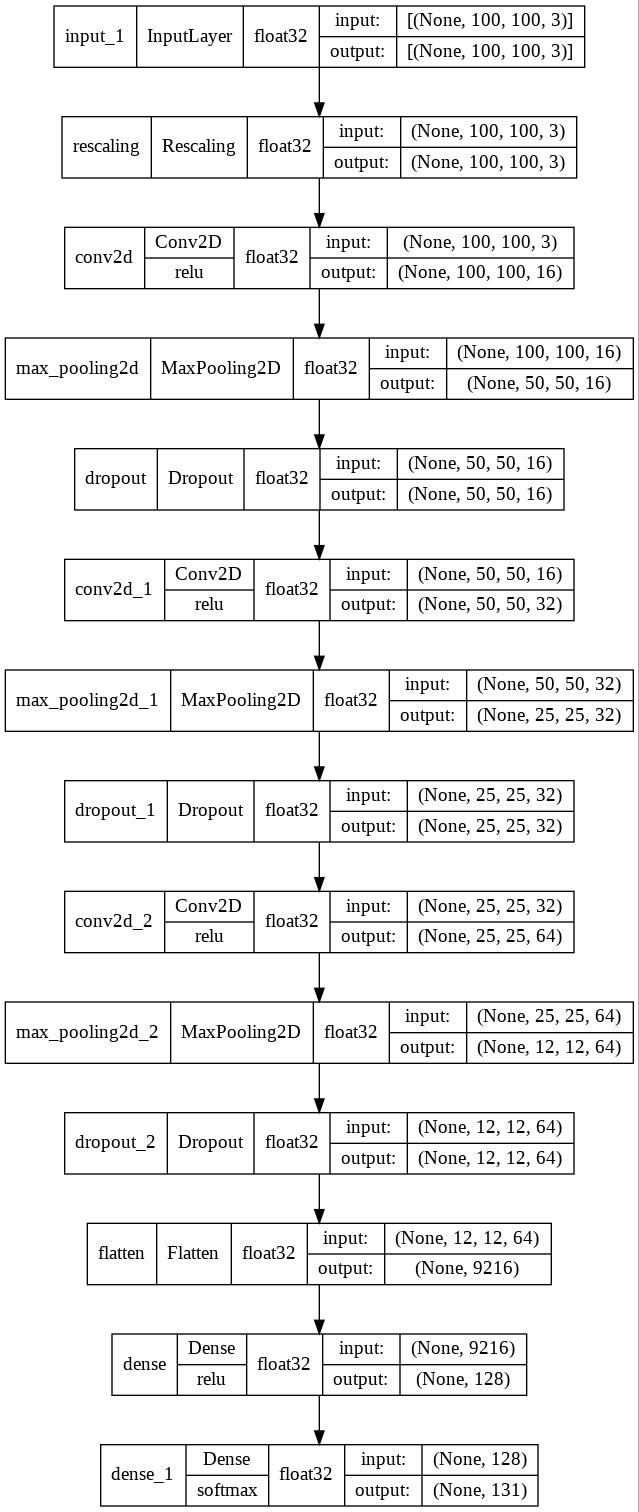

In [23]:
tf.keras.utils.plot_model(
    model,
    to_file='model.jpg',
    show_shapes=True, 
    show_dtype=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [24]:
early_stop = keras.callbacks.EarlyStopping(
    patience=3, 
    restore_best_weights=True
)

In [25]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
1693/1693 [==============================] - 57s 28ms/step - loss: 0.8694 - accuracy: 0.7764 - val_loss: 0.3770 - val_accuracy: 0.9121
Epoch 2/50
1693/1693 [==============================] - 46s 27ms/step - loss: 0.0899 - accuracy: 0.9699 - val_loss: 0.2959 - val_accuracy: 0.9240
Epoch 3/50
1693/1693 [==============================] - 46s 27ms/step - loss: 0.0583 - accuracy: 0.9820 - val_loss: 0.2207 - val_accuracy: 0.9427
Epoch 4/50
1693/1693 [==============================] - 45s 27ms/step - loss: 0.0512 - accuracy: 0.9844 - val_loss: 0.2917 - val_accuracy: 0.9370
Epoch 5/50
1693/1693 [==============================] - 46s 27ms/step - loss: 0.0420 - accuracy: 0.9874 - val_loss: 0.1432 - val_accuracy: 0.9685
Epoch 6/50
1693/1693 [==============================] - 46s 27ms/step - loss: 0.0354 - accuracy: 0.9891 - val_loss: 0.1934 - val_accuracy: 0.9575
Epoch 7/50
1693/1693 [==============================] - 45s 27ms/step - loss: 0.0331 - accuracy: 0.9901 - val_loss: 0.1709 -

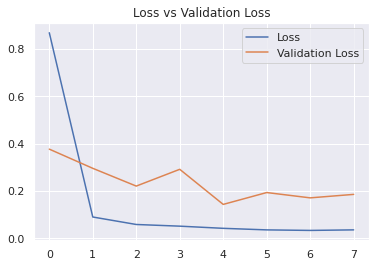

In [32]:
sns.set_theme()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs Validation Loss')
plt.show()

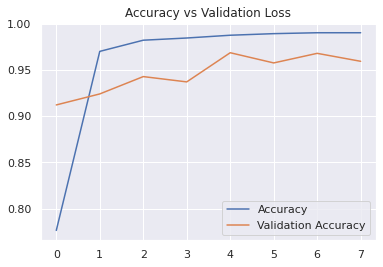

In [31]:
sns.set_theme()
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs Validation Loss')
plt.show()

In [28]:
model.save('model.h5')